In [3]:
import fasttext
import numpy as np
import pandas as pd

In [83]:
df = pd.read_csv('stock_description.csv').dropna()

In [84]:
df.description.head(10)

0     Agilent Technologies Inc. is a global leader i...
1     Alcoa is a global industry leader in bauxite, ...
2     ATA Inc. (ATA) is a provides computer-based te...
4     Artius Acquisition Inc Unit 1 Com & 13 Wt Exp ...
5        Artius Acquisition Inc - Warrants (01/01/9999)
6     Arlington Asset Investment Corp., an investmen...
7     Arlington Asset Investment Corp 7.00% Series B...
8     Arlington Asset Investment Corp 8250 Series C ...
9     American’s purpose is to care for people on li...
10    Altisource Asset Management Corporation provid...
Name: description, dtype: object

In [10]:
model = fasttext.train_unsupervised('stock_description.txt', model = 'cbow')
vocabulary = model.words
word_embeddings = np.array([model[word] for word in vocabulary])

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import logging

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, init = 'pca') # Changed the parameters for provided in the exercise for less KL divergence and better readibility
vis_data = tsne.fit_transform(word_embeddings)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10052 samples in 0.215s...
[t-SNE] Computed neighbors for 10052 samples in 23.721s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10052
[t-SNE] Computed conditional probabilities for sample 2000 / 10052
[t-SNE] Computed conditional probabilities for sample 3000 / 10052
[t-SNE] Computed conditional probabilities for sample 4000 / 10052
[t-SNE] Computed conditional probabilities for sample 5000 / 10052
[t-SNE] Computed conditional probabilities for sample 6000 / 10052
[t-SNE] Computed conditional probabilities for sample 7000 / 10052
[t-SNE] Computed conditional probabilities for sample 8000 / 10052
[t-SNE] Computed conditional probabilities for sample 9000 / 10052
[t-SNE] Computed conditional probabilities for sample 10000 / 10052
[t-SNE] Computed conditional probabilities for sample 10052 / 10052
[t-SNE] Mean sigma: 0.707025
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.658112
[t-SNE] K

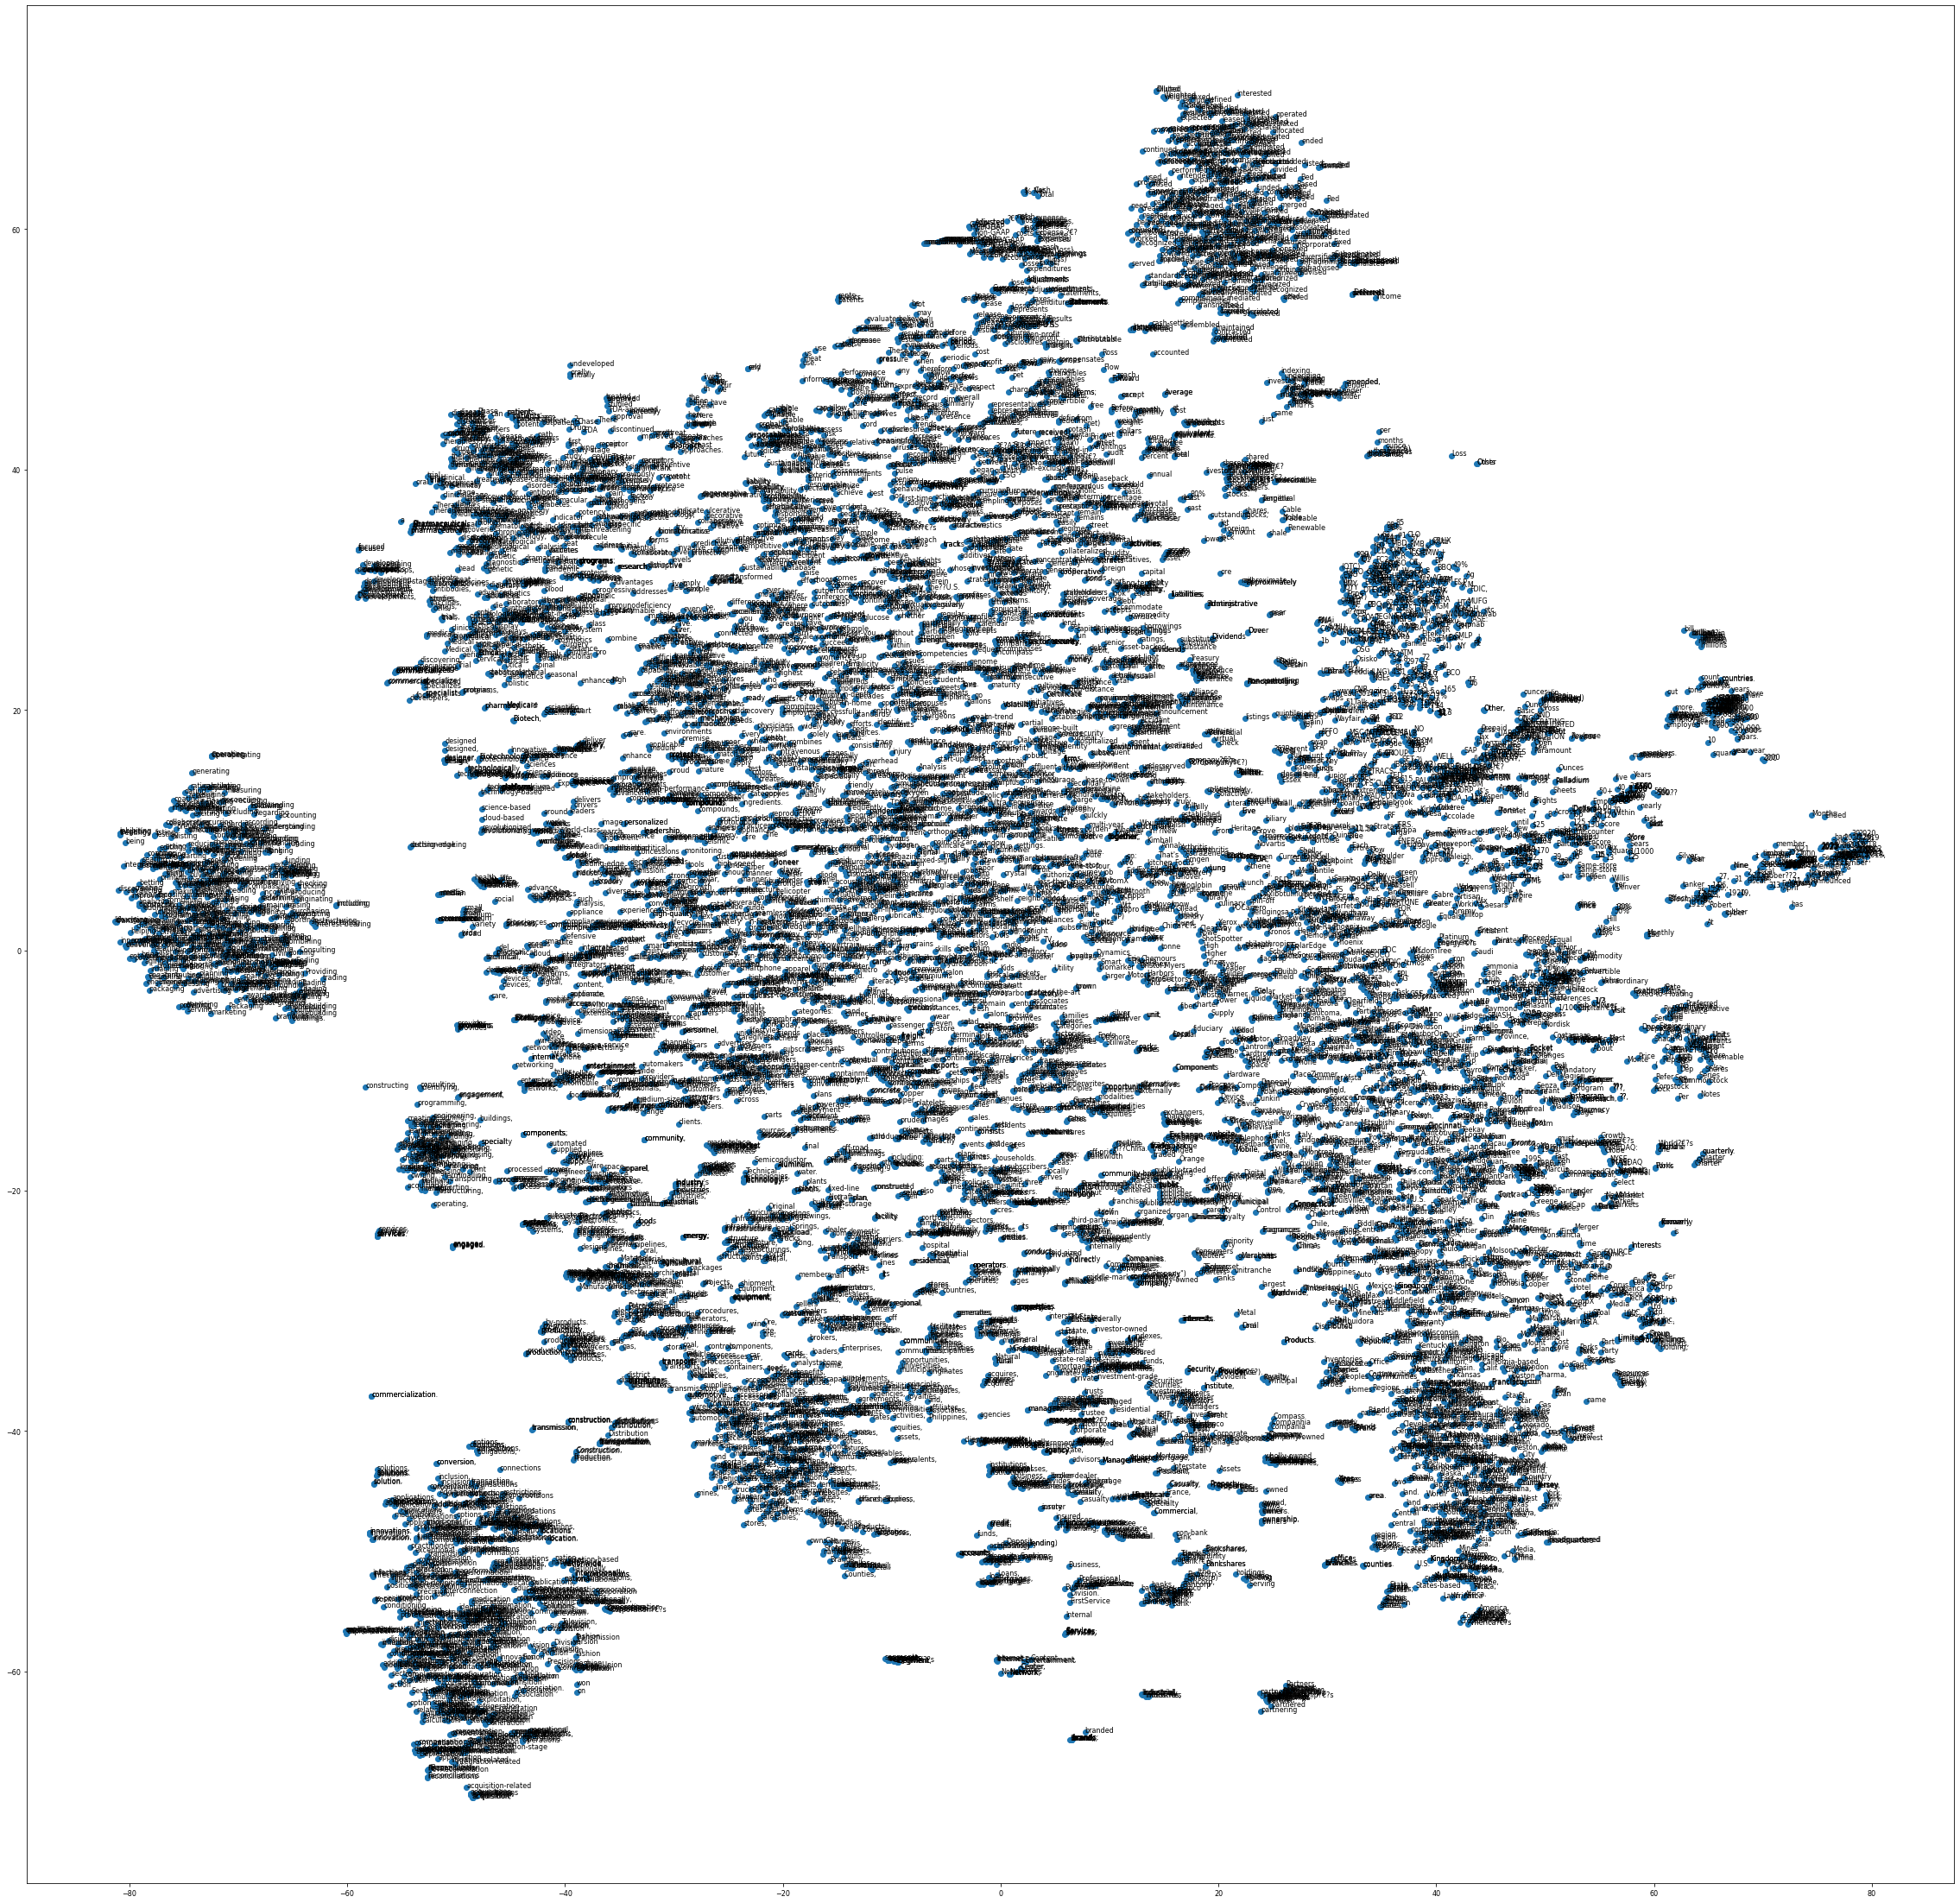

In [12]:
vis_data_x = vis_data[:,0]
vis_data_y = vis_data[:,1]

plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(40, 40)) 
plt.scatter(vis_data_x, vis_data_y)

for label, x, y in zip(vocabulary, vis_data_x, vis_data_y):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

def find_most_similar(input_term, word_embeddings, vocabulary, num_terms=3):
    term_embeddings_dict = {}
    for i,term in enumerate(vocabulary):
        term_embeddings_dict[term] = word_embeddings[i]
        
    if input_term not in term_embeddings_dict:
        return "Term not in the vocabulary"
    
    input_term_embedding = term_embeddings_dict[input_term]
    term_similarities = []
    for term, embedding in term_embeddings_dict.items():
        term_similarities.append([term, cosine_similarity(input_term_embedding.reshape((1,-1)), 
                                                          embedding.reshape((1,-1)))])
        
    sorted_terms = sorted(term_similarities, key = lambda x: -1 * x[1])[0:num_terms]
    
    return sorted_terms

# Note:
# cosine_similarity takes a matrix (of all word vectors) as input,
# so it's better not to loop through all terms to computer term_similarities for efficieny reasons
# I avoided doing this in this part for better readability, 
# although you will see matrix based solution in get_most_similar_documents
# in any case, you will never need to compute similarities by yourself, instead you can use:
# import gensim
# model = gensim.models.KeyedVectors.load_word2vec_format('model.vec')
# similar = model.most_similar(positive=['epfl'],topn=10)

find_most_similar('vaccine', word_embeddings, vocabulary, num_terms=5)

[['vaccine', array([[1.0000001]], dtype=float32)],
 ['drugs', array([[0.9787185]], dtype=float32)],
 ['antibiotic', array([[0.9741169]], dtype=float32)],
 ['antibody-drug', array([[0.97410476]], dtype=float32)],
 ['drug', array([[0.9738663]], dtype=float32)]]

In [77]:
# Loading of libraries and documents
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
import math
from collections import Counter

# Read a list of documents from a file. Each line in a file is a document
with open("stock_description.txt", encoding = 'UTF-8') as f:
    content = f.readlines()
        
original_documents = list(df.description)

In [86]:
# Create a dictionary of vectors for easier search
vector_dict = dict(zip(vocabulary, word_embeddings))

def aggregate_vector_list(vlist, aggfunc):
    if aggfunc == 'max':
        return np.array(vlist).max(axis=0)
    elif aggfunc == 'min':
        return np.array(vlist).min(axis=0)
    elif aggfunc == 'mean':
        return np.array(vlist).mean(axis=0)
    else:
        return np.zeros(np.array(vlist).shape[1])

possible_aggfuncs = ["max", "min", "mean"]

aggregated_doc_vectors = {}

# Aggregate vectors of documents beforehand
for aggfunc in possible_aggfuncs:
    aggregated_doc_vectors[aggfunc] = np.zeros((len(original_documents), word_embeddings.shape[1]))
    for index, doc in enumerate(original_documents):
        vlist = [vector_dict[token] for token in fasttext.tokenize(doc) if token in vector_dict]
        if(len(vlist) < 1):
            continue 
        else:
            aggregated_doc_vectors[aggfunc][index] = aggregate_vector_list(vlist, aggfunc) 

In [112]:
from sklearn.metrics.pairwise import cosine_similarity

def aggregate_query(query, aggfunc):
    tokens = fasttext.tokenize(query)
    if(len(tokens) == 1):
        if(tokens[0] in vocabulary):
            return vector_dict[tokens[0]]
    elif(len(tokens) > 1):
        vlist = []
        for token in tokens:
            if (token in vocabulary):
                vlist.append(vector_dict[token])
        
        return aggregate_vector_list(vlist, aggfunc)
    else:
        print("%s is not in the vocabulary." % (query))
    
def get_most_similar_documents(query_vector, aggfunc, k = 5):
    query_vector = query_vector.reshape(1, -1)
    # Calculate the similarity with each vector. 
    # Hint: Cosine similarity function takes a matrix as input so you do not need to loop through each document vector.
    sim = cosine_similarity(query_vector, aggregated_doc_vectors[aggfunc])
    
    # Rank the document vectors according to their cosine similarity with 
    indexes = np.argsort(sim, axis=-1, kind='quicksort', order=None) # This is sorted in ascending order
    indexes = indexes[0]
    indexes = indexes[::-1] # Convert to descending
    return indexes

def search_vec_embeddings(query, topk = 20, aggfunc = 'mean'):
    query_vector = aggregate_query(query, aggfunc)
    indexes = get_most_similar_documents(query_vector, aggfunc)
    # Print the top k documents
    indexes = indexes[0:topk]
    return df.iloc[indexes,:]

In [118]:
result = search_vec_embeddings('vaccine', aggfunc = 'mean')
result

,ticker,exchangeCode,description,startDate,name,endDate
288,ALT,NASDAQ,Altimmune is a clinical stage biopharmaceutica...,2005-10-06,Altimmune Inc,2020-11-20
3304,KDNY,NASDAQ,"Chinook Therapeutics, Inc. is a clinical-stage...",2015-04-15,Chinook Therapeutics Inc,2020-11-20
6279,VTVT,NASDAQ,vTv Therapeutics Inc. is a clinical-stage biop...,2015-07-30,vTv Therapeutics Inc - Class A,2020-11-20
4963,RDHL,NASDAQ,RedHill Biopharma Ltd. is a specialty biopharm...,2013-01-07,Redhill Biopharma,2020-11-20
55,ACET,NASDAQ,"Adicet Bio, Inc. is a biotechnology company di...",2018-01-26,Adicet Bio Inc,2020-11-20
1656,CYCCP,NASDAQ,"Cyclacel Pharmaceuticals, Inc. develops therap...",2005-11-30,Cyclacel Pharmaceuticals Inc,2020-11-20
5912,TRIL,NASDAQ,Trillium is an immuno-oncology company develop...,2005-03-23,Trillium Therapeutics Inc,2020-11-20
367,ANAB,NASDAQ,AnaptysBio is a clinical-stage biotechnology c...,2017-01-26,AnaptysBio Inc,2020-11-20
5031,RIGL,NASDAQ,"Rigel Pharmaceuticals, Inc. is a clinical-stag...",2000-11-29,Rigel Pharmaceuticals,2020-11-20
5667,SYBX,NASDAQ,Synlogic is pioneering the development of a no...,2015-10-01,Synlogic Inc,2020-11-20


In [124]:
result.iloc[3,2]

"RedHill Biopharma Ltd. is a specialty biopharmaceutical company primarily focused on gastrointestinal and infectious diseases. RedHill promotes the gastrointestinal drugs, Movantik ® for opioid-induced constipation in adults 9, Talicia ® for the treatment of Helicobacter pylori (H. pylori) infection in adults 10, and Aemcolo ® for the treatment of travelers' diarrhea in adults 11. RedHill's key clinical late-stage development programs include: (i) RHB-204,\xa0with an ongoing Phase 3 study for pulmonary nontuberculous mycobacteria (NTM) disease; (ii) opaganib (Yeliva ® ), a first - in - class SK2 selective inhibitor targeting multiple indications with a Phase 2/3 program for COVID-19 and Phase 2 studies for prostate cancer and cholangiocarcinoma ongoing; (iii) RHB-104, with positive results from a first Phase 3 study for Crohn's disease; (iv) RHB-102 ( Bekinda ® ), with positive results from a Phase 3 study for acute gastroenteritis and gastritis and positive results from a Phase 2 stu